<center><h1>Training models on the spectro-temporal features</h1></center>

In this notebook, I experiment with various models trained on mel-spectrograms.

[Loading the data](#loading)<br>
[CNNs](#cnns)<br>
[CNN Results](#results)<br>

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
from IPython.display import clear_output, display
import glob
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import classification_report, f1_score

In [4]:
DATA_PATH = "challengeA_data"
TRAIN_METADATA_PATH = os.path.join(DATA_PATH, "2022challengeA_train_modified.csv")
TRAIN_PATH = "challengeA_data/train"

In [5]:
train_df = pd.read_csv(TRAIN_METADATA_PATH, index_col=[0])
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

,file_id,emotion,encoded_emotion,origin,duration,sample_rate,n_channels
0,63d8a717-54e7-43d6-bcd7-8f4504ca001b.wav,neutral,4,crema,2.769437,16000.0,1
1,e639efb3-48f8-4735-8c42-8caf9acc6f53.wav,fear,2,crema,2.569250,16000.0,1
2,cae0047c-48a2-4b07-826f-912fa58e3e40.wav,sadness,5,crema,3.470125,16000.0,1
3,ac123685-eacc-4443-9fc6-97cc83a6b9c8.wav,sadness,5,crema,2.702688,16000.0,1
4,17f7ca5b-ac20-4584-9a3f-e0591f6bdd6a.wav,surprise,6,savee,6.289297,44100.0,1


<h3>Helper functions and useful variables</h3>

In [6]:
emotions = sorted(list(train_df["emotion"].unique()))
num_emotions = len(emotions)

keys = emotions
values = np.arange(7)
emotion_encoder = dict(zip(keys, values))
print(emotion_encoder)
print("\n")
emotion_decoder = dict(zip(list(emotion_encoder.values()), list(emotion_encoder.keys())))
print(emotion_decoder)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}


{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [7]:
def get_confusion_matrix(truth, predictions):
    """Returns the confusion matrix given predictions made by a model and the corresponding truth values.
        predictions: array of integers
        truth: array of integers
    """
    confusion_matrix = tf.math.confusion_matrix(truth, predictions, num_classes=7)
    return confusion_matrix

def get_accuracy_by_class(confusion_matrix, labels):
    """Returns a dictionary with the labels as keys and the accuracy of predictions made by a model as values.
        confusion_matrix: 2D confusion matrix
        labels: list of class names – in this case, emotions
    """
    accuracy_by_class = confusion_matrix.numpy().diagonal() / confusion_matrix.numpy().sum(axis=1)
    accuracy_by_class = [round(acc, 2) for acc in accuracy_by_class]
    class_accuracy_dict = dict(zip(emotions, accuracy_by_class))
    return class_accuracy_dict
    
def show_confusion_matrix(confusion_matrix):
    """Takes in predictions and the truth as arrays of scalars to create a confusion matrix. The
        confusion matrix is then displayed using seaborn. 
        predictions: array of integers
        truth: array of integers
    """
    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(confusion_matrix, annot=True, fmt="",
                    xticklabels=list(emotion_decoder.values()),
                    yticklabels=list(emotion_decoder.values()))
    plt.xlabel("Predicted", fontsize=10, labelpad=5)
    plt.ylabel("Truth", fontsize=10, labelpad=5)
    
def plot_performance(model_history):
    """Uses the model history dict obtained from model.fit().history to plot the 
    training loss and validation loss in one plot, and the training and validation accuracies in another plot."""
    metrics = model_history.history
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.xlabel("Epoch", labelpad=10, fontsize=10)
    plt.ylabel("Loss", labelpad=10, fontsize=10)
    plt.plot(model_history.epoch, metrics["loss"], metrics["val_loss"])
    plt.legend(["loss", "val_loss"])

    plt.subplot(1, 2, 2)
    plt.xlabel("Epoch", labelpad=10, fontsize=10)
    plt.ylabel("Accuracy", labelpad=10, fontsize=10)
    plt.plot(model_history.epoch, metrics["accuracy"], metrics["val_accuracy"])
    plt.legend(["accuracy", "val_accuracy"])

In [8]:
def get_mfcc_and_file_ids(files):
    list_mfccs = []
    label_ids = []
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sadness', 'surprise']
    
    num_files = len(files)
    batch_size = 50
    num_batches = num_files // batch_size
    if num_batches * batch_size < num_files:
        num_batches += 1
    
    num_files_loaded = 0
    for batch in range(num_batches):
        start_index = batch*batch_size
        for file_index in range(start_index, min(num_files, start_index+batch_size)):
            file = files[file_index]
            label = tf.strings.split(file, sep=os.path.sep)[-2]

            label_id = tf.math.argmax(label == emotions)
            label_id = tf.cast(label_id, tf.float32)

            mfccs = np.load(file)
            mfccs = tf.convert_to_tensor(mfccs)
            mfccs = mfccs[..., tf.newaxis]
            mfccs = tf.cast(mfccs, tf.float32)

            list_mfccs.append(mel_specgram)
            label_ids.append(label_id)
            num_files_loaded += 1
        
        clear_output(wait=True)
        progress = num_files_loaded / num_files * 100
        display("Loading files" + '.'*(batch%3+1))
        display(f"Progress: {round(progress, 2)}%")
    print("Complete!")
    
    list_mfccs = tf.convert_to_tensor(list_mfccs, dtype=tf.float32)
    label_ids = tf.convert_to_tensor(label_ids, dtype=tf.float32)
    
    return list_mfccs, label_ids

def get_mel_specgrams_and_label_ids(files):
    mel_specgrams = []
    label_ids = []
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sadness', 'surprise']
    
    num_files = len(files)
    batch_size = 50
    num_batches = num_files // batch_size
    if num_batches * batch_size < num_files:
        num_batches += 1
    
    num_files_loaded = 0
    for batch in range(num_batches):
        start_index = batch*batch_size
        for file_index in range(start_index, min(num_files, start_index+batch_size)):
            file = files[file_index]
            label = tf.strings.split(file, sep=os.path.sep)[-2]

            label_id = tf.math.argmax(label == emotions)
            label_id = tf.cast(label_id, tf.float32)

            mel_specgram = np.load(file)
            mel_specgram = tf.convert_to_tensor(mel_specgram)
            mel_specgram = mel_specgram[..., tf.newaxis]
            mel_specgram = tf.cast(mel_specgram, tf.float32)

            mel_specgrams.append(mel_specgram)
            label_ids.append(label_id)
            num_files_loaded += 1
        
        clear_output(wait=True)
        progress = num_files_loaded / num_files * 100
        display("Loading files" + '.'*(batch%3+1))
        display(f"Progress: {round(progress, 2)}%")
    print("Complete!")
    
    mel_specgrams = tf.convert_to_tensor(mel_specgrams, dtype=tf.float32)
    label_ids = tf.convert_to_tensor(label_ids, dtype=tf.float32)
    
    return mel_specgrams, label_ids

def create_dataset(mel_specgrams, label_ids):
    ds = tf.data.Dataset.from_tensor_slices((mel_specgrams, label_ids))
    # N.B.!!! In order to have every element considered for each random selection, the buffer size needs to be 
    # equal to or larger than the size of the dataset.
    ds = ds.shuffle(buffer_size=len(ds))
    
    return ds

<a id="loading"></a>
<h1>Loading the data</h1>

As was mentioned in the data augmentation notebook, when evaluating the performance of the model, it's very important that the model **hasn't seen the validation data in any shape or form, including augmentations of it.** So when holding out data for validation, I will also hold out augmentations of that data.

In [9]:
files = glob.glob("challengeA_data/mel_spectrogram/*/*.npy")
excluded = ["_warped.npy", "_noise.npy"]

random.shuffle(files)
original_files = [file for file in files if not any([file.endswith(sub) for sub in excluded])]
augmented_files = [file for file in files if any([file.endswith(sub) for sub in excluded])]

# I'll use 40% of the original files for validation and testing, and the remaining 60% + the augmented 
# files for training.
num_original_files = len(original_files)
num_augmented_files = len(augmented_files)
num_val = int(0.2 * num_original_files)
num_test = int(0.2 * num_original_files)
num_train = int(0.6 * num_original_files) + num_augmented_files
val_files = original_files[:num_val]
test_files = original_files[num_val:num_val+num_test]
train_files = original_files[num_val+num_test:]

# including only the augmented files that are not augmentations of the training and validation data
# Note that it's a very costly operation and takes some time to execute
augmented_files_to_include = [file for file in augmented_files \
                              if not any([file.split('/')[-1].replace("_warped.npy", "").replace("_noise.npy","") \
                                          in val_file for val_file in val_files]) \
                              and not any([file.split('/')[-1].replace("_warped.npy","").replace("_noise.npy", "") \
                                           in test_file for test_file in test_files])]
train_files += augmented_files_to_include

In [10]:
# y_train stores stores the labels as integers, where their value is determined by their 
# index in the list of emotions sorted in alphabetical order.
x_train, y_train = get_mel_specgrams_and_label_ids(train_files)

'Loading files.'

'Progress: 100.0%'

Complete!


In [11]:
x_val, y_val = get_mel_specgrams_and_label_ids(val_files)

'Loading files..'

'Progress: 100.0%'

Complete!


In [12]:
x_test, y_test = get_mel_specgrams_and_label_ids(test_files)

'Loading files..'

'Progress: 100.0%'

Complete!


In [13]:
train_ds = create_dataset(x_train, y_train)
val_ds = create_dataset(x_val, y_val)
test_ds = create_dataset(x_test, y_test)

batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

In [14]:
# Loading the testing data which will be used after each model is fitted to produce predictions.
test_data = []
test_labels = []
for mel_specgram, label in test_ds:
    test_data.append(mel_specgram)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

<a id="cnns"></a>
<h1>CNNs</h1>

For training, I will use the same training and validations sets for each model to ensure fairness in the comparison of models. I will train them each for a maximum of 100 epochs, using early stopping to ensure that the models' parameters are saved before overfitting occurs. <br>
The models are trained on a total of 44244 examples, batched into groups of 64.

In [15]:
EPOCHS = 100

The below two dictionaries will be used to save the histories and predictions of the models which will then be used to display the performance of the different models at the end of the notebook.

In [16]:
model_histories = {}
model_predictions = {}

<h3>Baseline model architecture</h3>

In [554]:
model = models.Sequential([
    layers.Input(shape=(128, 125, 1)),
    # Downsample the input.
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # Softmax must be the activation in the final layer to convert the vector of values into
    # a vector of probabilities.
    layers.Dense(7, activation="softmax"),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    # SparseCategoricalCrossentropy() is used for integer encoded labels, while CategoricalCrossentropy
    # is used for one-hot encoded labels.
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_31 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 conv2d_81 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_82 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_31 (Flatten)        (None, 12544)             0         
                                                                 
 dense_77 (Dense)            (None, 128)               1605760   
                                                     

In [555]:
model_histories["baseline"] = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=EPOCHS,
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3))

Epoch 1/100
226/226 [==============================] - 7s 27ms/step - loss: 1.4667 - accuracy: 0.4245 - val_loss: 1.1920 - val_accuracy: 0.5173
Epoch 2/100
226/226 [==============================] - 6s 25ms/step - loss: 1.1506 - accuracy: 0.5529 - val_loss: 1.1601 - val_accuracy: 0.5381
Epoch 3/100
226/226 [==============================] - 6s 25ms/step - loss: 1.0266 - accuracy: 0.6024 - val_loss: 1.1267 - val_accuracy: 0.5544
Epoch 4/100
226/226 [==============================] - 6s 25ms/step - loss: 0.9194 - accuracy: 0.6487 - val_loss: 1.1623 - val_accuracy: 0.5598
Epoch 5/100
226/226 [==============================] - 6s 25ms/step - loss: 0.8283 - accuracy: 0.6817 - val_loss: 1.1840 - val_accuracy: 0.5608
Epoch 6/100
226/226 [==============================] - 6s 26ms/step - loss: 0.7364 - accuracy: 0.7196 - val_loss: 1.2135 - val_accuracy: 0.5589


In [556]:
model_predictions["baseline"] = model.predict(test_data)

<h3>CNN architecture modeled off of FSER</h3>

The paper can be found <a href="https://arxiv.org/pdf/2109.07916.pdf">here</a>.

![title](images/fser_cnn_topology_cropped.png)

The image was also taken from the paper.

In [557]:
model = models.Sequential([
    layers.Input(shape=(128, 125, 1)),
    layers.Resizing(64, 64),
    
    layers.Conv2D(8, 5, activation="relu"),
    layers.MaxPool2D(2),
    layers.Dropout(0.2),
    
    layers.Conv2D(16, 5, activation="relu"),
    layers.MaxPool2D(2),
    layers.Dropout(0.2),
    
    layers.Conv2D(200, 5, activation="relu"),
    layers.MaxPool2D(2),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(7, activation="softmax")
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_32 (Resizing)      (None, 64, 64, 1)         0         
                                                                 
 conv2d_83 (Conv2D)          (None, 60, 60, 8)         208       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 30, 30, 8)        0         
 g2D)                                                            
                                                                 
 dropout_103 (Dropout)       (None, 30, 30, 8)         0         
                                                                 
 conv2d_84 (Conv2D)          (None, 26, 26, 16)        3216      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                

In [558]:
model_histories["fser"] = model.fit(train_ds, 
                                       validation_data=val_ds, 
                                       epochs=EPOCHS,
                                       callbacks=tf.keras.callbacks.EarlyStopping(
                                           monitor="val_loss", 
                                           patience=3)
                                      )

Epoch 1/100
226/226 [==============================] - 11s 46ms/step - loss: 1.6568 - accuracy: 0.3247 - val_loss: 1.3590 - val_accuracy: 0.4911
Epoch 2/100
226/226 [==============================] - 10s 43ms/step - loss: 1.2644 - accuracy: 0.5006 - val_loss: 1.2055 - val_accuracy: 0.5292
Epoch 3/100
226/226 [==============================] - 10s 44ms/step - loss: 1.1336 - accuracy: 0.5536 - val_loss: 1.1329 - val_accuracy: 0.5500
Epoch 4/100
226/226 [==============================] - 10s 44ms/step - loss: 1.0611 - accuracy: 0.5828 - val_loss: 1.1239 - val_accuracy: 0.5524
Epoch 5/100
226/226 [==============================] - 10s 44ms/step - loss: 1.0051 - accuracy: 0.6093 - val_loss: 1.0798 - val_accuracy: 0.5747
Epoch 6/100
226/226 [==============================] - 10s 44ms/step - loss: 0.9513 - accuracy: 0.6290 - val_loss: 1.0778 - val_accuracy: 0.5742
Epoch 7/100
226/226 [==============================] - 10s 44ms/step - loss: 0.9096 - accuracy: 0.6477 - val_loss: 1.0756 - val_ac

In [559]:
model_predictions["fser"] = model.predict(test_data)

<h3>Complex architecture</h3>

In [17]:
model = models.Sequential([
    layers.Input(shape=(128, 125, 1)),
    layers.Resizing(64, 64),
    
    layers.Conv2D(32, 5, activation="relu"),
    layers.MaxPool2D(2),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, 5, activation="relu"),
    layers.MaxPool2D(2),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(7, activation="softmax")
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                    

In [18]:
model_histories["complex"] = model.fit(train_ds, 
                                       validation_data=val_ds, 
                                       epochs=EPOCHS,
                                       callbacks=tf.keras.callbacks.EarlyStopping(
                                           monitor="val_loss", 
                                           patience=3)
                                      )

Epoch 1/100
226/226 [==============================] - 15s 54ms/step - loss: 1.8895 - accuracy: 0.1960 - val_loss: 1.7080 - val_accuracy: 0.2859
Epoch 2/100
226/226 [==============================] - 11s 51ms/step - loss: 1.5905 - accuracy: 0.3533 - val_loss: 1.4308 - val_accuracy: 0.3942
Epoch 3/100
226/226 [==============================] - 12s 54ms/step - loss: 1.3986 - accuracy: 0.4341 - val_loss: 1.3238 - val_accuracy: 0.4644
Epoch 4/100
226/226 [==============================] - 12s 52ms/step - loss: 1.2806 - accuracy: 0.4874 - val_loss: 1.2280 - val_accuracy: 0.4916
Epoch 5/100
226/226 [==============================] - 12s 51ms/step - loss: 1.2135 - accuracy: 0.5190 - val_loss: 1.2046 - val_accuracy: 0.5366
Epoch 6/100
226/226 [==============================] - 11s 50ms/step - loss: 1.1679 - accuracy: 0.5369 - val_loss: 1.1760 - val_accuracy: 0.5312
Epoch 7/100
226/226 [==============================] - 12s 51ms/step - loss: 1.1280 - accuracy: 0.5577 - val_loss: 1.1568 - val_ac

In [19]:
model_predictions["complex"] = model.predict(test_data)

<a id="results"></a>
<h1>CNN Results</h1>

<h3>Baseline model</h3>

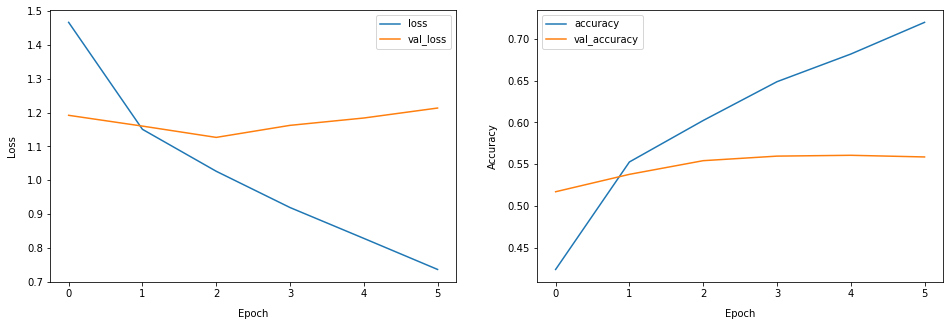

In [563]:
plot_performance(model_histories["baseline"])

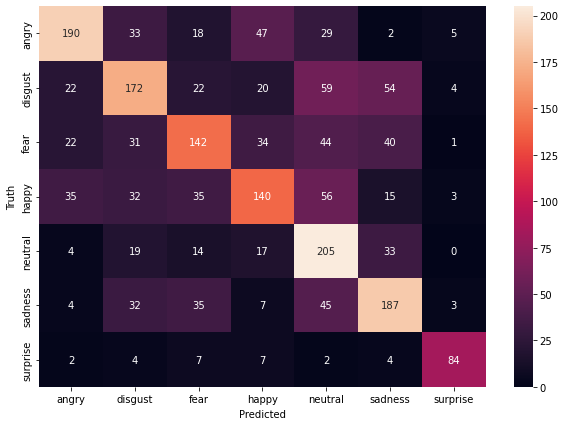

In [564]:
confusion_matrix = get_confusion_matrix(test_labels, np.argmax(model_predictions["baseline"], axis=1))
show_confusion_matrix(confusion_matrix)

In [565]:
print(classification_report(test_labels, np.argmax(model_predictions["baseline"], axis=1), target_names=emotions))

              precision    recall  f1-score   support

       angry       0.68      0.59      0.63       324
     disgust       0.53      0.49      0.51       353
        fear       0.52      0.45      0.48       314
       happy       0.51      0.44      0.48       316
     neutral       0.47      0.70      0.56       292
     sadness       0.56      0.60      0.58       313
    surprise       0.84      0.76      0.80       110

    accuracy                           0.55      2022
   macro avg       0.59      0.58      0.58      2022
weighted avg       0.56      0.55      0.55      2022



<h3>FSER</h3>

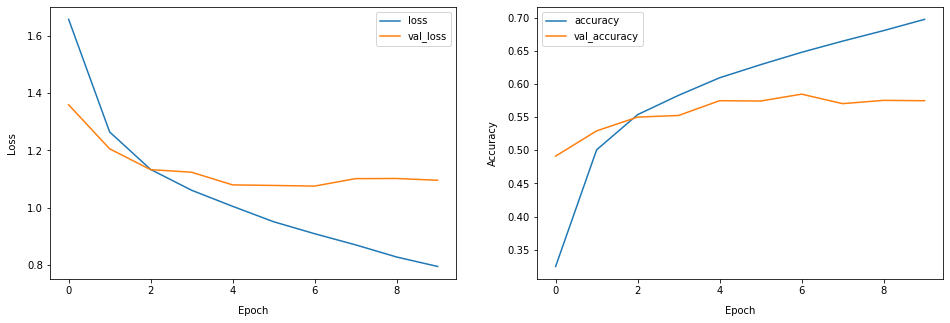

In [566]:
plot_performance(model_histories["fser"])

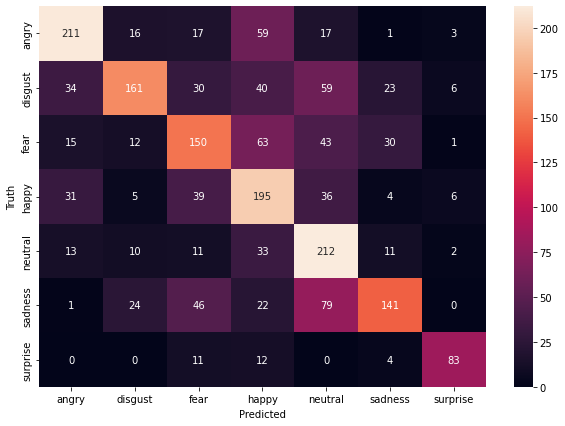

In [567]:
confusion_matrix = get_confusion_matrix(test_labels, np.argmax(model_predictions["fser"], axis=1))
show_confusion_matrix(confusion_matrix)

In [568]:
print(classification_report(test_labels, np.argmax(model_predictions["fser"], axis=1), target_names=emotions))

              precision    recall  f1-score   support

       angry       0.69      0.65      0.67       324
     disgust       0.71      0.46      0.55       353
        fear       0.49      0.48      0.49       314
       happy       0.46      0.62      0.53       316
     neutral       0.48      0.73      0.57       292
     sadness       0.66      0.45      0.54       313
    surprise       0.82      0.75      0.79       110

    accuracy                           0.57      2022
   macro avg       0.62      0.59      0.59      2022
weighted avg       0.60      0.57      0.57      2022



<h3>Complex</h3>

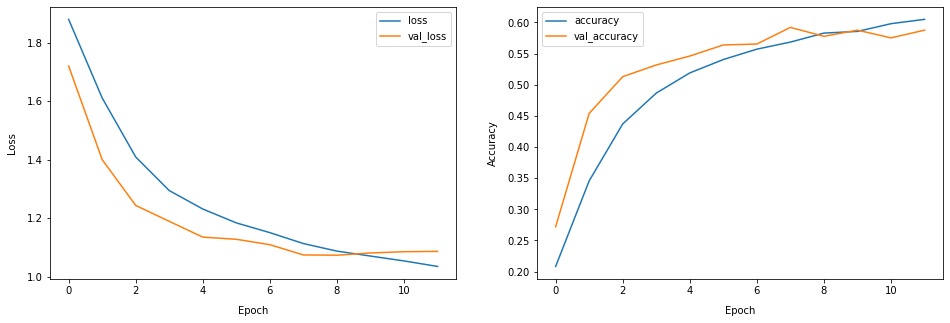

In [569]:
plot_performance(model_histories["complex"])

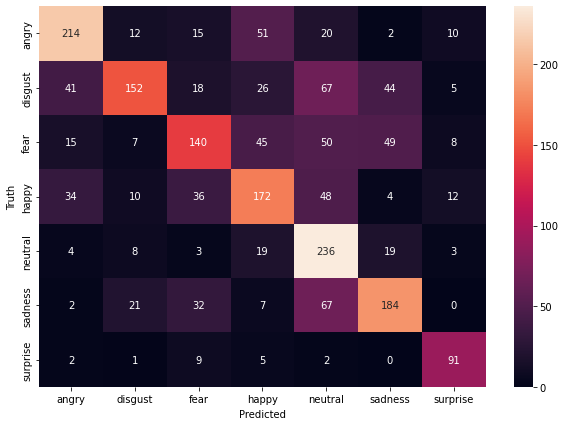

In [570]:
confusion_matrix = get_confusion_matrix(test_labels, np.argmax(model_predictions["complex"], axis=1))
show_confusion_matrix(confusion_matrix)

In [571]:
print(classification_report(test_labels, np.argmax(model_predictions["complex"], axis=1), target_names=emotions))

              precision    recall  f1-score   support

       angry       0.69      0.66      0.67       324
     disgust       0.72      0.43      0.54       353
        fear       0.55      0.45      0.49       314
       happy       0.53      0.54      0.54       316
     neutral       0.48      0.81      0.60       292
     sadness       0.61      0.59      0.60       313
    surprise       0.71      0.83      0.76       110

    accuracy                           0.59      2022
   macro avg       0.61      0.61      0.60      2022
weighted avg       0.61      0.59      0.58      2022



In [20]:
f1_score(test_labels, np.argmax(model_predictions["complex"], axis=1), average="micro")

0.5850642927794263

It seems that the architecture of the CNN had minimal effect on performance. The best score was achieved by the complex model, which was a macro-averaged weighted F1-score of 0.6.